# Binary-Class Tabular Model for Liver Disease Patients Using Python and XGBoost
### David Lowe
### November 2, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Liver Disease Patients dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: This dataset contains over 30,000 cases of liver disease diagnosis results. The researcher trained machine learning models using this dataset to test the feasibility of applying machine learning techniques for making diagnostic predictions.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 86.97%. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 99.87%.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Liver Disease Patients Dataset

Dataset ML Model: Binary-Class classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/datasets/abhi8923shriv/liver-disease-patient-dataset

One source of potential performance benchmarks: https://www.kaggle.com/datasets/abhi8923shriv/liver-disease-patient-dataset/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sat Oct 29 15:20:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Result'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'LPD_train.csv'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-abhi8923shriv-liver-disease-patient/LPD_train.csv'
df_dataset_import = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Age  Gender  Total_Bilirubin  Direct_Bilirubin  \
0  65.0  Female              0.7               0.1   
1  62.0    Male             10.9               5.5   
2  62.0    Male              7.3               4.1   
3  58.0    Male              1.0               0.4   
4  72.0    Male              3.9               2.0   

   Alkphos_Alkaline_Phosphotase  Sgpt_Alamine_Aminotransferase  \
0                         187.0                           16.0   
1                         699.0                           64.0   
2                         490.0                           60.0   
3                         182.0                           14.0   
4                         195.0                           27.0   

   Sgot_Aspartate_Aminotransferase  Total_Protiens  ALB_Albumin  \
0                             18.0             6.8          3.3   
1                            100.0             7.5          3.2   
2                             68.0             7.0          3.3   
3         

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              30689 non-null  float64
 1   Gender                           29789 non-null  object 
 2   Total_Bilirubin                  30043 non-null  float64
 3   Direct_Bilirubin                 30130 non-null  float64
 4   Alkphos_Alkaline_Phosphotase     29895 non-null  float64
 5   Sgpt_Alamine_Aminotransferase    30153 non-null  float64
 6   Sgot_Aspartate_Aminotransferase  30229 non-null  float64
 7   Total_Protiens                   30228 non-null  float64
 8   ALB_Albumin                      30197 non-null  float64
 9   Albumin_Globulin_Ratio           30132 non-null  float64
 10  Result                           30691 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 2.6+ MB


In [11]:
print(df_dataset_import.describe())

                Age  Total_Bilirubin  Direct_Bilirubin  \
count  30689.000000     30043.000000      30130.000000   
mean      44.107205         3.370319          1.528042   
std       15.981043         6.255522          2.869592   
min        4.000000         0.400000          0.100000   
25%       32.000000         0.800000          0.200000   
50%       45.000000         1.000000          0.300000   
75%       55.000000         2.700000          1.300000   
max       90.000000        75.000000         19.700000   

       Alkphos_Alkaline_Phosphotase  Sgpt_Alamine_Aminotransferase  \
count                  29895.000000                   30153.000000   
mean                     289.075364                      81.488641   
std                      238.537589                     182.158850   
min                       63.000000                      10.000000   
25%                      175.000000                      23.000000   
50%                      209.000000                      

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Age                                  2
Gender                             902
Total_Bilirubin                    648
Direct_Bilirubin                   561
Alkphos_Alkaline_Phosphotase       796
Sgpt_Alamine_Aminotransferase      538
Sgot_Aspartate_Aminotransferase    462
Total_Protiens                     463
ALB_Albumin                        494
Albumin_Globulin_Ratio             559
Result                               0
dtype: int64
Total number of NaN in the dataframe:  5425


In [13]:
# Get grouping size for the target variable
# print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Age  Gender  Total_Bilirubin  Direct_Bilirubin  \
0  65.0  Female              0.7               0.1   
1  62.0    Male             10.9               5.5   
2  62.0    Male              7.3               4.1   
3  58.0    Male              1.0               0.4   
4  72.0    Male              3.9               2.0   

   Alkphos_Alkaline_Phosphotase  Sgpt_Alamine_Aminotransferase  \
0                         187.0                           16.0   
1                         699.0                           64.0   
2                         490.0                           60.0   
3                         182.0                           14.0   
4                         195.0                           27.0   

   Sgot_Aspartate_Aminotransferase  Total_Protiens  ALB_Albumin  \
0                             18.0             6.8          3.3   
1                            100.0             7.5          3.2   
2                             68.0             7.0          3.3   
3         

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              30689 non-null  float64
 1   Gender                           29789 non-null  object 
 2   Total_Bilirubin                  30043 non-null  float64
 3   Direct_Bilirubin                 30130 non-null  float64
 4   Alkphos_Alkaline_Phosphotase     29895 non-null  float64
 5   Sgpt_Alamine_Aminotransferase    30153 non-null  float64
 6   Sgot_Aspartate_Aminotransferase  30229 non-null  float64
 7   Total_Protiens                   30228 non-null  float64
 8   ALB_Albumin                      30197 non-null  float64
 9   Albumin_Globulin_Ratio           30132 non-null  float64
 10  target                           30691 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 2.6+ MB


In [16]:
print(df_dataset_import.describe())

                Age  Total_Bilirubin  Direct_Bilirubin  \
count  30689.000000     30043.000000      30130.000000   
mean      44.107205         3.370319          1.528042   
std       15.981043         6.255522          2.869592   
min        4.000000         0.400000          0.100000   
25%       32.000000         0.800000          0.200000   
50%       45.000000         1.000000          0.300000   
75%       55.000000         2.700000          1.300000   
max       90.000000        75.000000         19.700000   

       Alkphos_Alkaline_Phosphotase  Sgpt_Alamine_Aminotransferase  \
count                  29895.000000                   30153.000000   
mean                     289.075364                      81.488641   
std                      238.537589                     182.158850   
min                       63.000000                      10.000000   
25%                      175.000000                      23.000000   
50%                      209.000000                      

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Age                                  2
Gender                             902
Total_Bilirubin                    648
Direct_Bilirubin                   561
Alkphos_Alkaline_Phosphotase       796
Sgpt_Alamine_Aminotransferase      538
Sgot_Aspartate_Aminotransferase    462
Total_Protiens                     463
ALB_Albumin                        494
Albumin_Globulin_Ratio             559
target                               0
dtype: int64
Total number of NaN in the dataframe:  5425


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
1    21917
2     8774
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (30691, 11) df_features_train.shape: (30691, 10) df_target_train.shape: (30691,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

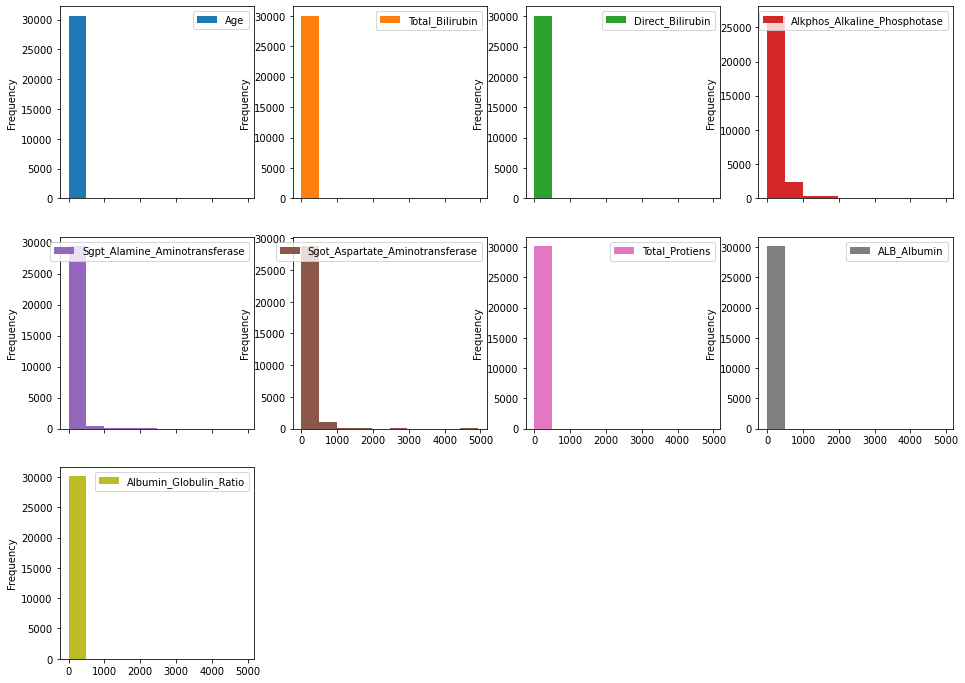

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

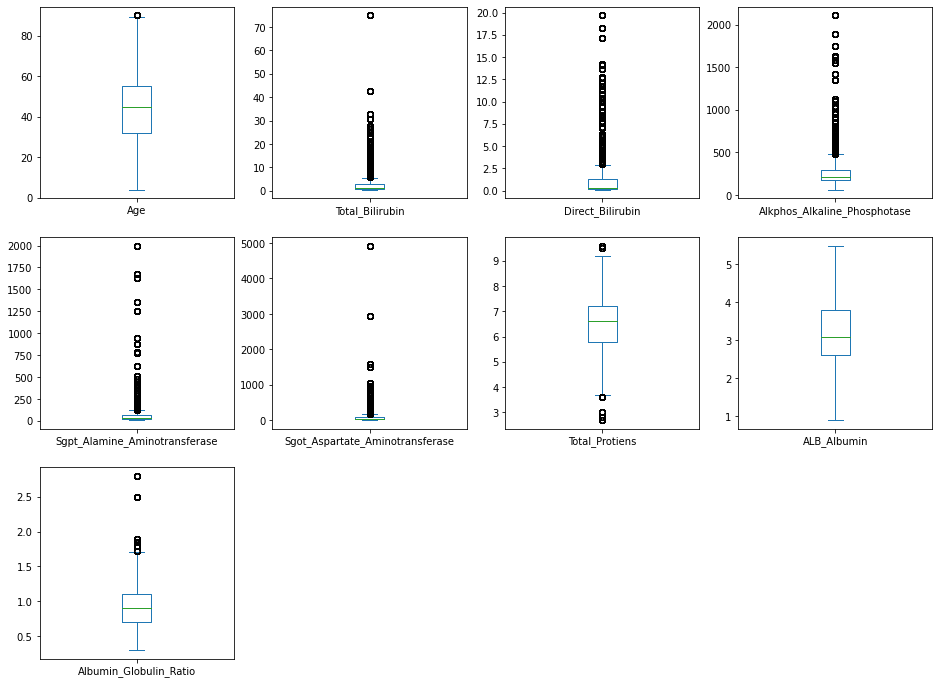

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

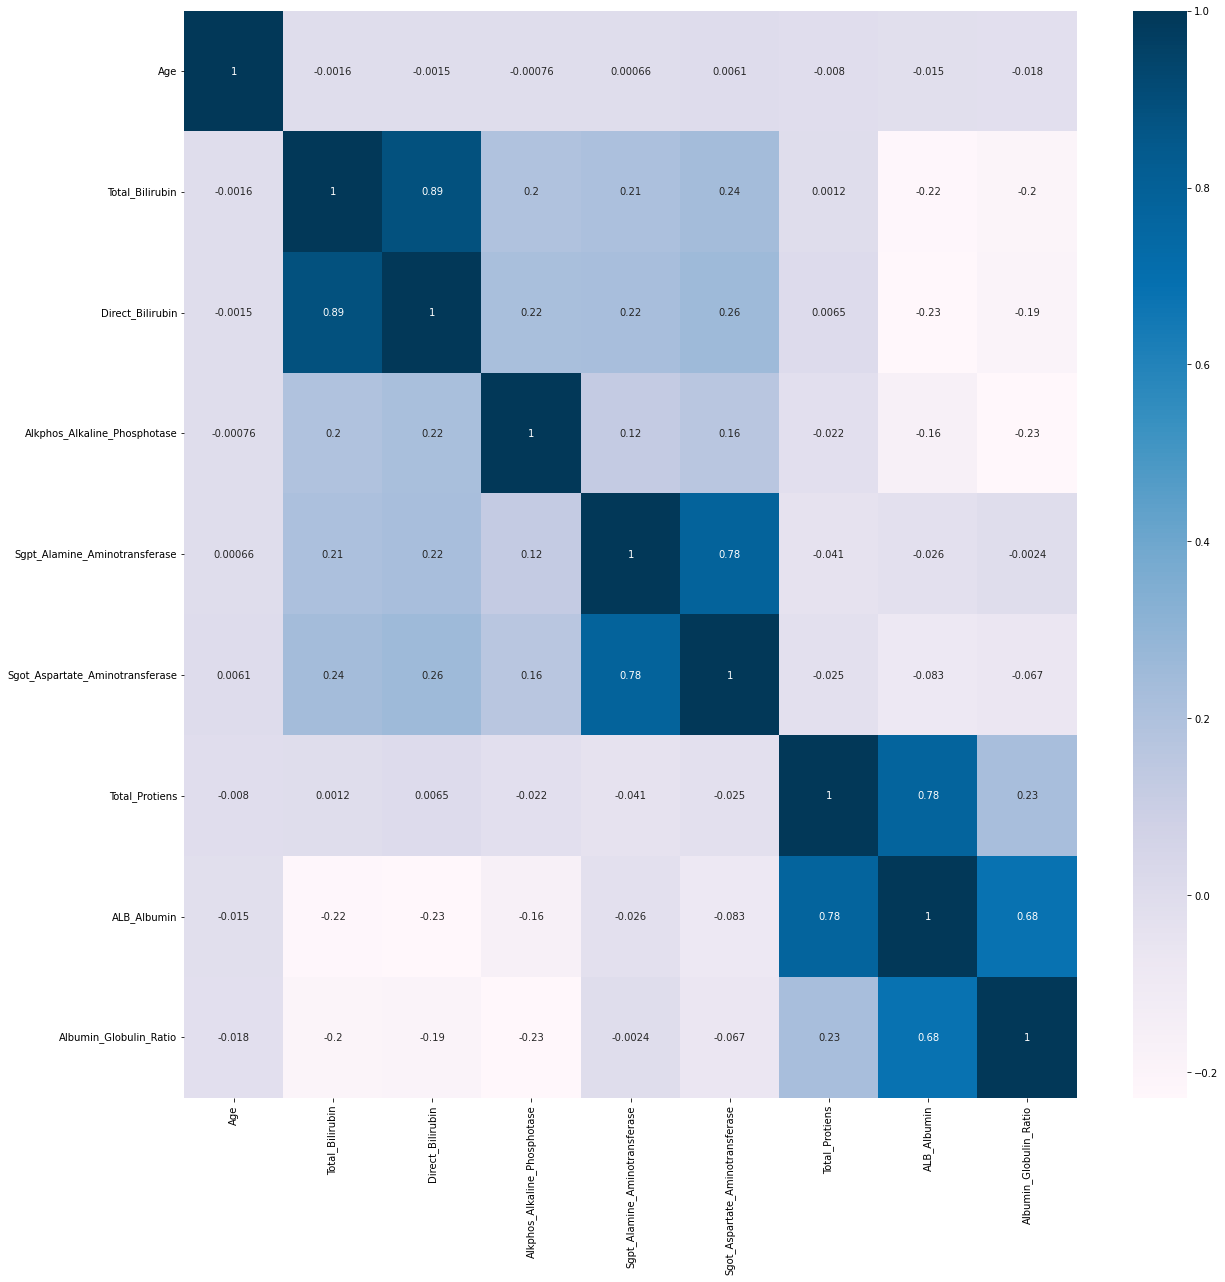

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [28]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 9
Number of categorical columns: 1
Total number of columns in the feature dataframe: 10


In [29]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (30691, 10) to array_features_train.shape: (30691, 12)


### 3.b) Training Data Balancing

In [30]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [31]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [32]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (30691, 12) array_target_train.shape: (30691,)


In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [34]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [35]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [36]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')))

In [37]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.869734 (0.008089)
XGBClassifier(eval_metric='logloss', random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:07.745534 

Average metrics (accuracy) from all models: 0.86973375660567
Total training time for all models: 0:00:07.790755


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


### 4.b) Algorithm Tuning

In [38]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [39]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best: 0.998338 using {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500}
0.869734 (0.008089) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.942720 (0.007040) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.980157 (0.003812) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.991138 (0.001870) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.993940 (0.001186) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.870809 (0.009908) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.942720 (0.009418) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.978952 (0.002697) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.991529 (0.001955) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.993158 (0.002166) with: {'max_depth': 3, 'min_child_weight': 2, 'n_est

In [40]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 1
Best n_estimators parameter: 500


In [41]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best: 0.998762 using {'colsample_bytree': 0.7, 'subsample': 0.7}
0.998762 (0.000648) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.998599 (0.000850) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.998729 (0.000763) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.998729 (0.000659) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.998338 (0.000880) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.998469 (0.000772) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.998436 (0.000822) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.998403 (0.001004) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.998501 (0.000488) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.998501 (0.000731) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.998241 (0.000549) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.998306 (0.000680) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.998469 (0.000772) with: {'cols

In [42]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 0.7
Best subsample parameter: 0.7


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


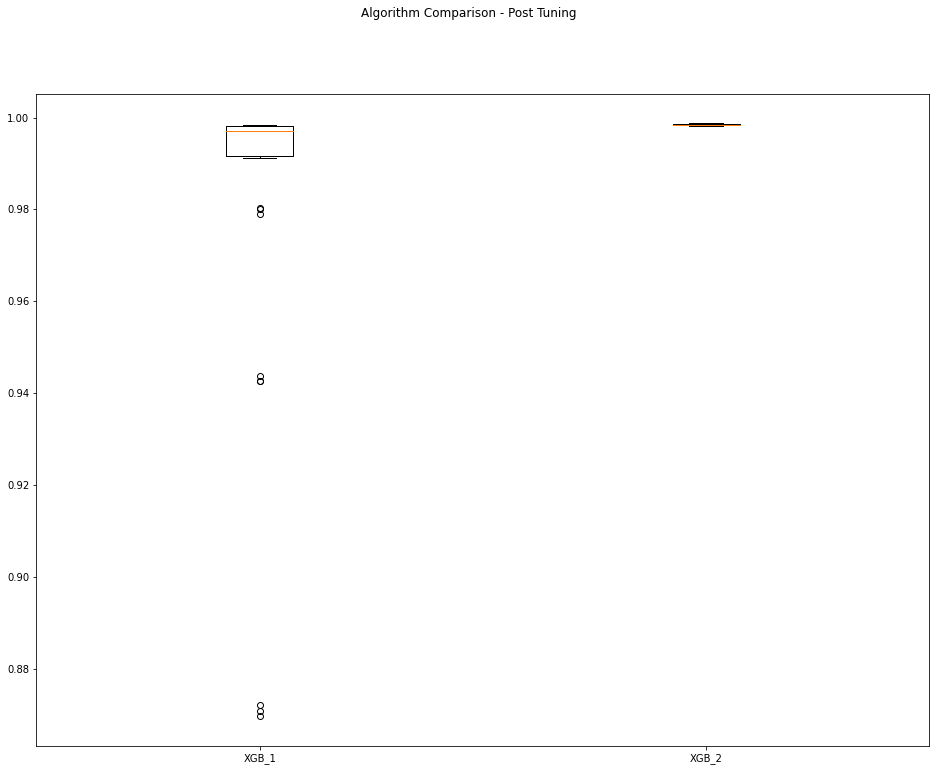

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=0.7, eval_metric='logloss', max_depth=6,
              n_estimators=500, random_state=888, subsample=0.7,
              tree_method='gpu_hist', use_label_encoder=False)


In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:23:05.459206
